# 線形多層ニューラルネットワークの学習ダイナミクス

## 線形多層ニューラルネットワークにおける学習ダイナミクスと知識の獲得

> A. M. Saxe, J. L. McClelland, S. Ganguli. "**A mathematical theory of semantic development in deep neural networks**". *PNAS.* (2019). ([arXiv](https://arxiv.org/abs/1810.10531)). ([PNAS](https://www.pnas.org/content/early/2019/05/16/1820226116))

### モデルと学習
入力 $\mathbf{x}$ は「もの」の項目(例えばカナリア，犬，サーモン，樫など)，出力 $\mathbf{y}$はそれぞれの項目の性質・特性となっている．例えばカナリア(Canary)は成長し(Grow)，動き(Move)，空を飛べる(Fly)ので，Canaryという入力に対し，ネットワークが出力するのはGrow, Move, Flyとなる．モデルは3層の全結合線形ネットワークである．

$$
\hat{\mathbf{y}} =  \mathbf{ W}^{2} \mathbf{ W}^{1}\mathbf{x} 
$$

ただし非線形な活性化関数が無いことに注意しよう．このようなネットワークを線形ニューラルネットワーク (linear neural network)と呼ぶ．勘の良い読者であれば $ \mathbf{ W}^{s}=\mathbf{ W}^{2} \mathbf{W}^{1}$として， 上のネットワークは

$$
\hat{\mathbf{y}} =  \mathbf{ W}^{s}\mathbf{x}
$$

とまとめることができると気づくであろう．なので線形な活性化関数で深いニューラルネットワークを構築しても何の意味もなく，それゆえ非線形な活性化関数が必要となる．しかし，**勾配降下法で学習させると**3層と2層のネットワークの学習ダイナミクスはそれぞれ異なるものとなり，得られる解にも違いが生まれる．加えて，深い(3層の)ネットワークである場合のみ，幼児の発達における非線形な現象が説明できる．

3層ネットワークの学習(重みの更新)は誤差逆伝搬から導かれる次の2式により行う．

$$
\begin{aligned} \tau \frac{d}{dt} \mathbf{ W}^{1}&=(\mathbf{W}^2)^\top ( \mathbf{\Sigma}^{yx} - \mathbf{W}^2 \mathbf{W}^1 \mathbf{\Sigma}^{x})\\
\tau \frac{d}{dt} \mathbf{W}^{2}&=(\mathbf{\Sigma}^{yx} - \mathbf{W}^{2} \mathbf{W}^1 \mathbf{\Sigma}^{x}) (\mathbf{W}^1)^\top
\end{aligned}
$$

ただし，$ \mathbf{\Sigma}^{x}$は入力間の関係を表す行列，$\mathbf{\Sigma}^{yx}$は入出力の関係を表す行列である．

### 特異値分解(SVD)による学習ダイナミクスの解析
学習ダイナミクスは$ \mathbf{\Sigma}^{yx}$に対する特異値分解(singular value decomposition; SVD)を用いて説明できる．

$$
\mathbf{\Sigma}^{yx}=\mathbf{USV}^\top
$$

行列$ \mathbf{ S}$の対角成分の非ゼロ要素が特異値である．次に学習途中の時刻$(t)$における$\hat{\mathbf{\Sigma}}^{yx}(t)=\mathbf{W}^2 (t) \mathbf{W}^1(t) \mathbf{\Sigma}^{x}$に対してSVDを実行し，特異値$\mathbf{A}(t)=[a_{\alpha}(t)]$を得る．この $a _ {\alpha}(t)$だが，3層のネットワークでは大きな特異値から先に学習されるのに対し，2層のネットワークでは全ての特異値が同時に学習される．このダイナミクスだが，**低ランク近似** (low-rank approximation)が生じていて，特異値の大きな要素から学習されていると捉えることができる．学習が進むとランクが大きくなっていく，ということである．低ランク近似の例として，SVDによる画像の圧縮と復元を見てみよう．カメラマンの画像に対し，低ランク近似を行い，ランクを上げていく．するとランクが上がるにつれて，画像が鮮明になる．

In [1]:
using PyPlot, LinearAlgebra, TestImages
eye(n) = Matrix(I, n, n)

eye (generic function with 1 method)

In [2]:
# Low-rank approximation with SVD
function LowRankApprox(U, s, V; rank=1)
    Ur, sr, Vr = U[:, 1:rank], s[1:rank], V[:, 1:rank]
    return Ur * diagm(sr) * Vr'
end;

In [29]:
img = convert(Array{Float64}, testimage("cameraman"));
U, s, V = svd(img); # PythonとJuliaでVに転置がかかっているか否かの違いあり．
ranklist = [5, 15, 25]
nr = length(ranklist)
img_approx = [LowRankApprox(U, s, V, rank=r) for r in ranklist];

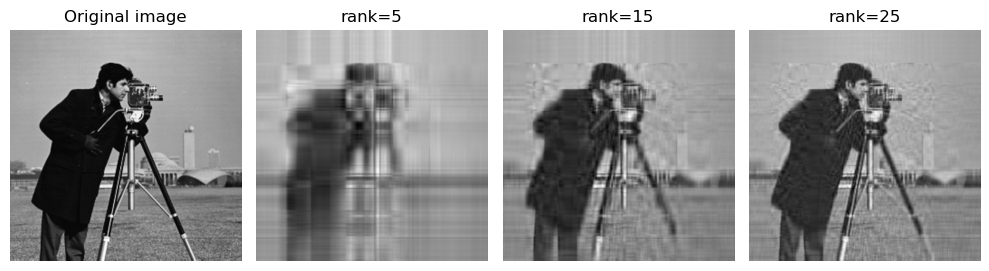

In [30]:
figure(figsize=(10, 3))
subplot(1, nr+1, 1); imshow(img, cmap="gray"); title("Original image"); axis("off")
for i in 1:nr
    subplot(1, nr+1, i+1); imshow(img_approx[i], cmap="gray"); title("rank="*string(ranklist[i])); axis("off")
end
tight_layout()

これと同じことが知識の獲得において生じていると見なすことができる．

In [5]:
# Set initial values
N1, N2, N3 = 4, 16, 7
Σyx = [ones(4)'; ones(2)' zeros(2)'; zeros(2)' ones(2)'; eye(4)];
Σx = eye(N1)
_, s, _ = svd(Σyx);
eps = 1e-2
W1, W2 = eps*rand(N2,N1), eps*rand(N3,N2) # weight for deep
Ws = eps*rand(N3,N1) # weight for shallow

#Simulation & training
dt = 0.005
Nt = 1500
A, B = zeros(Nt, N1), zeros(Nt, N1); # Singular values for deep, shallow

In [6]:
# Shallow network
for t in 1:Nt
    # Update weights
    Ws += (Σyx - Ws * Σx) * dt   
    # SVD & save results
    Σ̂yx = Ws * Σx
    _, a, _ = svd(Σ̂yx)
    B[t, :] += a
end

In [7]:
# Deep network
for t in 1:Nt
    # Update weights
    δ = Σyx - W2 * W1 * Σx
    W1 += (W2' * δ) * dt
    W2 += (δ * W1') * dt
    # SVD & save results
    Σ̂yx = W2 * W1 * Σx
    _, a, _ = svd(Σ̂yx)
    A[t, :] += a
end

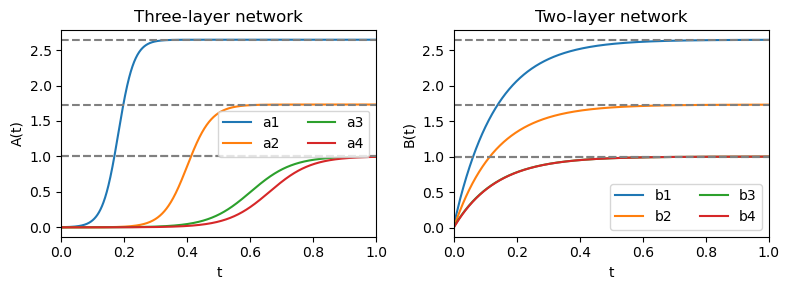

In [26]:
# Plot results
T = range(0, 1, length=Nt)
figure(figsize=(8,3))
subplot(1,2,1); title("Three-layer network")
for i in 1:4
    plot(T, A[:,i], label="a"*string(i))
    axhline(s[i], color="gray", linestyle="dashed")
end
xlim(0, 1); xlabel("t"); ylabel("A(t)"); legend(ncol=2)
subplot(1,2,2); title("Two-layer network")
for i in 1:4
    plot(T, B[:,i], label="b"*string(i))
    axhline(s[i], color="gray", linestyle="dashed")
end
xlim(0, 1); xlabel("t"); ylabel("B(t)"); legend(ncol=2)
tight_layout()

3層線形ネットワーク (deep)では大きな特異値から学習が始まっているのが分かる．また，それぞれの特異値の学習においてはシグモイド関数様の急速な学習段階が見られる．一方で2層線形ネットワーク (shallow)では全ての特異値の学習が初めから起こっていることがわかる．パラメータが少ないため，収束はこちらの方が速い．

このモデルが面白い理由の一つとして，知識の混同（例えば『芋虫には骨がある』）の仕組みを提供することがある．発達において，大きい特異値から先に学習されるため，「動く」，「成長する」などの動物の要素が先に獲得される．身の回りの動物のほとんどが「骨を持つ」ので，**低ランク近似により，『芋虫にも骨がある』と錯覚してしまう**のではないか，という仮説が立てられている．

## 線形多層ニューラルネットワークにおける勾配降下法による低ランク解の獲得

> Jing, L., Zbontar, J. & LeCun, Y. **Implicit Rank-Minimizing Autoencoder**. *NeurIPS' 20*, 2020. <https://arxiv.org/abs/2010.00679>

([Arora et al., *NeurIPS' 19*. 2019](https://arxiv.org/abs/1905.13655))は深層線形ニューラルネットワークが低ランクの解を導出できることを理論的及び実験的に実証した．([Gunasekar et al., *NeurIPS' 18*. 2018](https://arxiv.org/abs/1806.00468))は，線形畳み込みニューラルネットワークにおいて勾配降下が正則化作用を持つことを示した．

証明は省略するが，([Arora et al., *NeurIPS' 19*. 2019](https://arxiv.org/abs/1905.13655))におけるTheorem 3.を紹介する．まず，$N$層の線形多層ニューラルネットワークを考え，$W_j \in \mathbb{R}^{d_j \times d_{j−1}}$を$j$層の重みとする．$t$を学習のタイムステップとし，$W(t) \in \mathbb{R}^{d \times d^\prime}$を重み行列を全て乗じた行列とする (ただし$d := d_N, d^\prime := d_0$)．つまり$W(t):=\prod_{j=1}^N W_j(t)$である．

ここで$W(t)$を特異値分解し，$W(t) = U(t)S(t)V^\top(t)$と表現する．$S(t)$は対角行列で，その要素を$\sigma_1(t), \ldots , \sigma_{\min\{d, d^\prime\}}(t),$とする．これが$W(t)$の特異値となる．さらに$U(t), V (t)$の列ベクトルをそれぞれ $\mathbf{u}_1(t), \ldots, \mathbf{u}_{\min\{d, d^\prime\}}(t)$, および $\mathbf{v}_1(t), \ldots, \mathbf{v}_{\min\{d,d^\prime \}}(t)$とする．このとき，特異値$ \sigma_r(t)\ (r=1, \ldots, \min\{d,d^\prime \})$の損失関数$\mathcal{L}(W(t))$に対する勾配降下法による変化は

$$
\frac{d \sigma_r(t)}{dt} = - N \cdot \left[\sigma_r(t)\right]^{1 - \frac{1}{N}} \cdot \left\langle \nabla \mathcal{L}(W(t)) , \mathbf{u}_r(t) \mathbf{v}_r^\top(t) \right\rangle
$$

と表される (Arora et al., 2019; Theorem 3)．(1)式で重要なのは$\left[\sigma_r(t)\right]^{1 - \frac{1}{N}}$の項である．これは$N\geq 2$のときに**特異値$\sigma_r(t)\ (\geq 0)$を小さくするような正則化作用が生じる**ことを意味している．一方で，隠れ層が1つのニューラルネットワーク ($N=1$)の場合 (1)式は

$$
\frac{d \sigma_r(t)}{dt} = - \left\langle \nabla \mathcal{L}(W(t)) , \mathbf{u}_r(t) \mathbf{v}_r^\top(t) \right\rangle
$$

となり，正則化作用は消失する．

このように線形多層ニューラルネットワークを勾配降下法で学習させると**陰的正則化(implicit regularization)** により低ランクの解が得られるということが複数の研究により明らかとなっている（線形多層ニューラルネットワークの陰的正則化に関して日本語で書かれた資料としては鈴木大慈先生の[深層学習の数理](https://www.slideshare.net/trinmu/ss-161240890)のスライドp.64, 65がある)．Jingらはこの性質を用い，**Autoencoderに線形層を複数追加**するという簡便な方法で低次元表現を学習する決定論的Autoencoder (**Implicit Rank-Minimizing Autoencoder; IRMAE)** を考案した．